In [2]:
import random as rd
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt

MUTATION_CHANCE = .3
MUTATION_DECREESE_PER_GENERATION = (.3-.10)/500
CROSSOVER_CHANCE = .3
MUTATION_SIGMA = .4

def functionB(x):
    return 1

def functionA(x):
    y = math.sin(x)
    if y < 0:
        y = 0
    return y

def seperation_bias(i, s):
    b = 0
    for j in range(len(s)):
        if s[i]!=s[j]:
            b += 1/abs((math.pow(s[i]-s[j], 2)))
        else:
            b += 1000
    return -1*b/len(s)/1000

def combfunc(x, s):
    for i in range(len(s)):
        if x==s[i]:
            return seperation_bias(i, s) + functionA(x)

def dist_func(x, y):
    return math.pow(x[0]-y[0],2)+.01

def random_population(count, axies):
    population = np.empty((count, len(axies)))
    for i in range(count):
        for j in range(len(axies)):
            axis = axies[j]
            population[i][j] = rd.uniform(axis[0], axis[1])
    return population

def mutate(population, axies, generations=0):
    newdna = np.empty(population.shape)
    for i in range(population.shape[0]):
        for j in range(population.shape[1]):
            c = population[i][j]
            axis = axies[j]
            if rd.random() < max(0, MUTATION_CHANCE-MUTATION_DECREESE_PER_GENERATION*generations):
                c = rd.uniform(axis[0], axis[1])
            newdna[i][j] = c
    return newdna

def my_gauss(val, axis):
    newval = rd.gauss(val, MUTATION_SIGMA)
    return max(min(newval, axis[1]), axis[0])

def radial_mutation(population, axies, generations=0, function=my_gauss):
    newdna = np.empty(population.shape)
    for i in range(population.shape[0]):
        for j in range(population.shape[1]):
            c = population[i][j]
            axis = axies[j]
            c = function(c, axis)
            newdna[i][j] = c
    return newdna

def cross(a, b):
    c = np.empty((a.shape[0]))
    for i in range(a.shape[0]):
        if rd.random() < CROSSOVER_CHANCE:
            if rd.random() > .5:
                c[i] = a[i]
            else:
                c[i] = b[i]
        else:
            c[i] = (a[i] + b[i])/2
    return c

def crossover(weighted_population):
    new_population = np.empty((weighted_population.shape[0],weighted_population.shape[1]-1))
    s = 0
    for i in range(int(weighted_population.shape[0])):
        c1 = weighted_population[np.random.choice(np.array(list(range(weighted_population[:, 1:].shape[0]))), p=weighted_population[:, 0])][1:]
        c2 = weighted_population[np.random.choice(np.array(list(range(weighted_population[:, 1:].shape[0]))), p=weighted_population[:, 0])][1:]
        s+=c1[0]+c2[0]
        new_population[i] = cross(c1, c2)
    return new_population

def graphical_crossover(population, distance=dist_func, weighting=None):
    if weighting is None:
        weighting = population[:, 0]
        population = population[:, 1:]
        
    sum_dist = np.empty(population.shape[0])
    for i in range(population.shape[0]):
        sum_dist[i] = 0
        for j in range(population.shape[0]):
            sum_dist[i] += 1/distance(population[i], population[j])
    all_edges = np.empty((int(math.pow(population.shape[0], 2)), population.shape[1]))#1:?
    all_edge_weights = np.empty((int(math.pow(population.shape[0], 2)), 1))
    for i in range(population.shape[0]):
        for j in range(population.shape[0]):
            all_edges[i+j*population.shape[0]] = cross(population[i], population[j])
            all_edge_weights[i+j*population.shape[0]] = 1/(sum_dist[i]*distance(population[i], population[j])) * weighting[i]
            
    new_population = np.empty(population.shape)
    for i in range(population.shape[0]):
        choice = np.random.choice(np.arange(all_edges.shape[0]), p=all_edge_weights[:, 0])
        new_population[i] = all_edges[choice]
    return new_population

def graphical_crossover_old(population, distance=dist_func, weighting=None):
    if weighting is None:
        weighting = population[:, 0]
        population = population[:, 1:]
    new_population = np.empty(population.shape)
    sum_dist = np.empty(population.shape[0])
    all_edges = np.empty((population.shape[0]*population.shape[0],weighted_population.shape[1]))
    for i in range(weighted_population.shape[0]):
        sum_dist[i] = 0
        for j in range(weighted_population.shape[0]):
            sum_dist[i] += distance(weighted_population[i][1:], weighted_population[j][1:])
    k = 0
    for i in range(weighted_population.shape[0]):
        for j in range(weighted_population.shape[0]):
            if i!=j:
                all_edges[k][1:] = cross(weighted_population[i][1:], weighted_population[j][1:])
                all_edges[k][0] = (weighted_population[i][0]/sum_dist[i] + weighted_population[j][0]/sum_dist[j])*distance(weighted_population[i][1:], weighted_population[j][1:])/2#probability
            else:
                all_edges[k][1:] = weighted_population[i][1:]
                all_edges[k][0] = weighted_population[i][0]*distance(weighted_population[i][1:], weighted_population[i][1:])/sum_dist[i]
            k += 1
    for i in range(weighted_population.shape[0]):
        choice = np.random.choice(np.arange(all_edges.shape[0]), p=all_edges[:, 0])
        new_population[i] = all_edges[choice][1:]
    return new_population
    
def Population_Algorithm(function=value_function, population=100, time_constraint=10, axies=[(0, 10)]):
    population = random_population(population, axies)
    #step_by_step = np.empty((population.shape[0], population.shape[1], 1000))
    start_time = time.time()
    while time.time() < start_time + time_constraint:
        #print(population)
        #print(np.apply_along_axis(function, 1, population))
        weighting = np.apply_along_axis(function, 1, population).reshape(population.shape)
        weighting[weighting < 0] = 0
        weighted_population = np.concatenate((weighting/np.sum(weighting), population), axis=1)
        population = radial_mutation(graphical_crossover(weighted_population), axies, generations=i)
        #update_progress((time.time()-start_time)/time_constraint)
    return population

NameError: name 'value_function' is not defined

Progress: [####################] 100.0%
1.0648104892398795


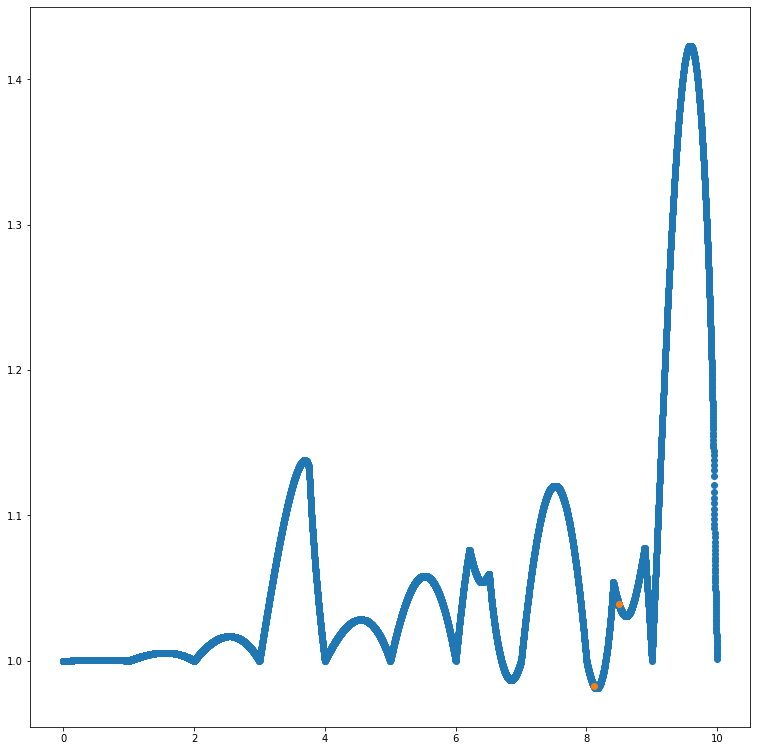

In [219]:
#Standard Genetic Algorithm
population = Population_Algorithm(function=value_function, population=2)
#print(len(population))
#print('GA done. Making view.')
tmp = list(range(0, int(10*1000)))
points = []
for t in tmp:
    points.append(t/1000)
function_vals = [value_function(np.array([x])) for x in points]
plt.scatter(points, function_vals)
#print(np.apply_along_axis(functionA, 1, population))
pop_vals = [value_function(x) for x in population]
print(value_function(population.reshape((population.shape[0]))))
plt.scatter(population, pop_vals)

In [218]:
#print(value_function(population.reshape((population.shape[0]))))

1.4497996586227857


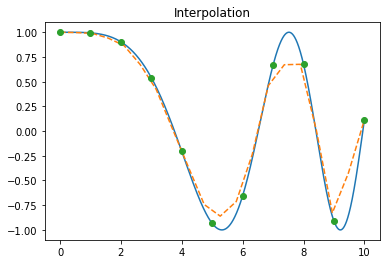

In [289]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)

func_space = np.linspace(0, 10, num=10000, endpoint=True)
func_val = np.cos(-func_space**2/9.0)
new_x = np.linspace(0, 10, num=20, endpoint=True)
plt.plot(func_space, func_val, '-', new_x, f(new_x), '--', x, y, 'o')
plt.title('Interpolation')
plt.show()

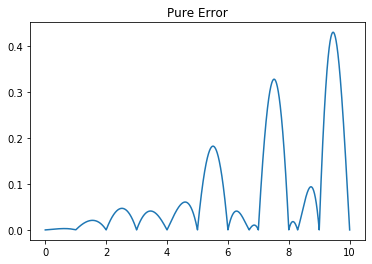

In [290]:
pure_error = abs(np.cos(-func_space**2/9.0)-f(func_space))
plt.plot(func_space, pure_error, '-')
plt.title('Pure Error')
plt.show()

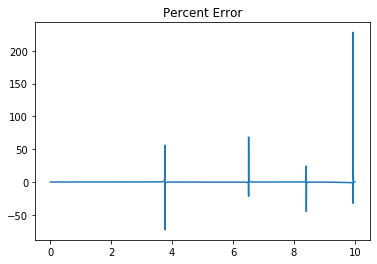

In [291]:
percent_error = pure_error/func_val
plt.plot(func_space, percent_error, '-')
plt.title('Percent Error')
plt.show()

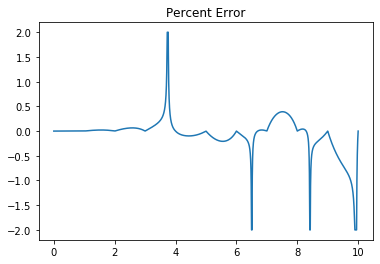

In [292]:
#use relative percent error cause passes through 0
rel_perc_error = 2*(np.cos(-func_space**2/9.0)-f(func_space))/(abs(np.cos(-func_space**2/9.0))+abs(f(func_space)))
plt.plot(func_space, rel_perc_error, '-')
plt.title('Percent Error')
plt.show()

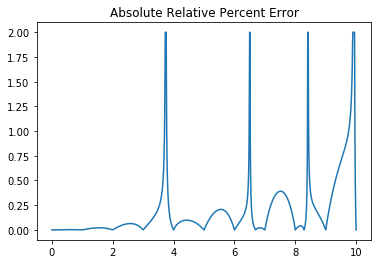

In [294]:
abs_rel_perc_error = abs(rel_perc_error)
plt.plot(func_space, abs_rel_perc_error, '-')
plt.title('Absolute Relative Percent Error')
plt.show()

In [7]:
#say our goal is to minimize this
np.average(abs_rel_perc_error)

0.19430523856465748

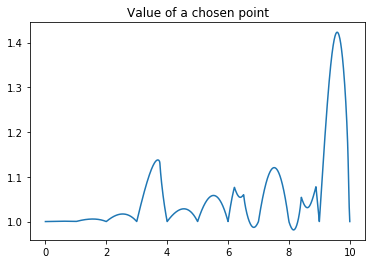

In [8]:
#showing single point things
def __eq__(xarr):
    yarr = np.cos(-xarr**2/9.0)
    return yarr

def value_at_point(new_point, current_points, r=[0,10], function=__eq__):
    new_point=new_point[0]
    base_interp = interp1d(current_points, __eq__(current_points))
    new_points = np.append(current_points, np.array([new_point]), axis=0)
    new_interp = interp1d(new_points, __eq__(new_points))
    func_space = np.linspace(r[0], r[1], num=10000, endpoint=True)
    old_val = abs((__eq__(func_space)-base_interp(func_space))/(abs(__eq__(func_space))+abs(base_interp(func_space))))
    new_val = abs((__eq__(func_space)-new_interp(func_space))/(abs(__eq__(func_space))+abs(new_interp(func_space))))
    return np.average(old_val)/np.average(new_val)

func_space = np.linspace(0, 10, num=10000, endpoint=True).reshape((10000, 1))
og_points = np.linspace(0, 10, num=11, endpoint=True)
value_of_points = np.apply_along_axis(value_at_point, 1, func_space, og_points)
plt.plot(func_space, value_of_points, '-')
plt.title('Value of a chosen point')
plt.show()

In [9]:
from matplotlib.mlab import griddata



ImportError: cannot import name 'griddata'

(1, 1000)
(1000, 1)
(1000, 1000)


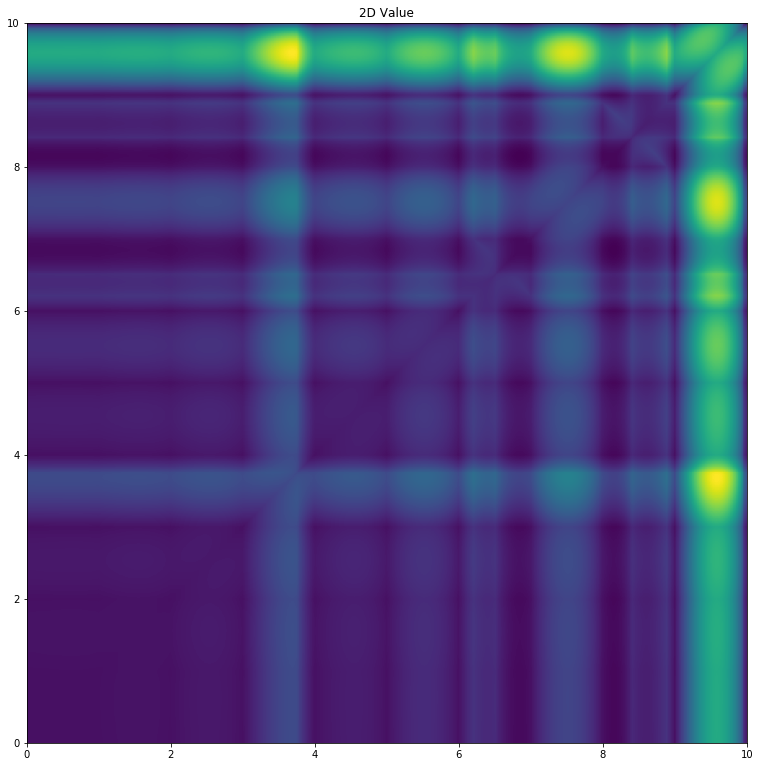

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 720x720 with 0 Axes>

In [295]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
matplotlib.rcParams['figure.subplot.left'] = 0
matplotlib.rcParams['figure.subplot.bottom'] = 0
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 1
print(xx_space.shape)
print(yy_space.shape)
print(out_space.shape)
plt.pcolormesh(xx_space, yy_space, out_space)#, figsize=(10,10))
plt.title('2D Value')
plt.show()
plt.colorbar()

In [11]:
#two point interference
import numpy as np
from scipy.interpolate import interp1d

def __eq__(xarr):
    #print(xarr)
    yarr = np.cos(-xarr**2/9.0)
    return yarr

def value_at_points(new_points, current_points, r=[0,10], function=__eq__):
    base_interp = interp1d(current_points, __eq__(current_points))
    new_points = np.append(current_points, new_points, axis=0)
    #print(new_points)
    new_interp = interp1d(new_points, __eq__(new_points))
    func_space = np.linspace(r[0], r[1], num=10000, endpoint=True)
    old_val = abs((__eq__(func_space)-base_interp(func_space))/(abs(__eq__(func_space))+abs(base_interp(func_space))))
    new_val = abs((__eq__(func_space)-new_interp(func_space))/(abs(__eq__(func_space))+abs(new_interp(func_space))))
    return np.average(old_val)/np.average(new_val)

func_space = np.linspace(0, 10, num=1000, endpoint=True).reshape((1000, 1))
og_points = np.linspace(0, 10, num=11, endpoint=True)
xx_space, yy_space = np.meshgrid(func_space, func_space, sparse=True)
out_space = np.empty((xx_space.shape[1], yy_space.shape[0]))
print(out_space.shape)
for i in range(xx_space.shape[1]):
    for j in range(yy_space.shape[0]):
        x = xx_space[0, i]
        y = yy_space[j]
        out_space[i][j] = value_at_points(np.array([x, y]), og_points)
    update_progress(i*1.0/xx_space.shape[1])
print(out_space)
#value_of_points = np.apply_along_axis(value_at_point, 1, func_space, og_points)

#plt.title('Value of a chosen point')
#plt.show()


Progress: [####################] 99.9%
[[1.         1.00001592 1.00003183 ... 1.03482109 1.0163102  1.        ]
 [1.00001592 1.00001592 1.00003183 ... 1.03483813 1.01632663 1.00001592]
 [1.00003183 1.00003183 1.00003183 ... 1.03485517 1.01634307 1.00003183]
 ...
 [1.03482109 1.03483813 1.03485517 ... 1.03482109 1.0348218  1.03482109]
 [1.0163102  1.01632663 1.01634307 ... 1.0348218  1.0163102  1.0163102 ]
 [1.         1.00001592 1.00003183 ... 1.03482109 1.0163102  1.        ]]


In [12]:
#Other Optimizers
import numpy as np
from scipy.interpolate import interp1d

def __eq__(xarr):
    #print(xarr)
    yarr = np.cos(-xarr**2/9.0)
    return yarr

def value_function(new_points):#much arbitrary... very name
    r = [0,10]
    function = __eq__
    current_points = np.linspace(0, 10, num=11, endpoint=True)
    
    base_interp = interp1d(current_points, __eq__(current_points))
    new_points = np.append(current_points, new_points, axis=0)
    new_interp = interp1d(new_points, __eq__(new_points))
    func_space = np.linspace(r[0], r[1], num=10000, endpoint=True)
    old_val = abs((__eq__(func_space)-base_interp(func_space))/(abs(__eq__(func_space))+abs(base_interp(func_space))))
    new_val = abs((__eq__(func_space)-new_interp(func_space))/(abs(__eq__(func_space))+abs(new_interp(func_space))))
    return np.average(old_val)/np.average(new_val)

In [268]:
import GeneticAlgorithms
import ParticleSwarm
import importlib
importlib.reload(GeneticAlgorithms)
importlib.reload(ParticleSwarm)
number_of_points = 50
print("reloaded")


reloaded


In [244]:
ga = GeneticAlgorithms.GeneticAlgorithm(params={"fitness_function": lambda_value, "axes": [(0, 10)]*number_of_points, "population_size": 100})

In [245]:
value_function(ga.run())

20.494668564365195

In [246]:
pa = GeneticAlgorithms.PopulationAlgorithm(params={"fitness_function": lambda_value, "axes": [(0, 10)], "population_size": number_of_points})

In [247]:
res = pa.run()
res = res.reshape(res.shape[0])

In [248]:
value_function(res)

1.2569179628274092

In [249]:
pso = ParticleSwarm.ParticleSwarmOptimization(params={"fitness_function": lambda_value, "axes": [(0, 10)]*number_of_points, "population_size": 100})

In [250]:
out = pso.run()

In [251]:
print(out)

[8.75799456 1.89170269 8.33850859 5.13709414 6.54594362 3.94817002
 6.2032387  2.0050778  1.27149351 8.72930672 5.49546829 8.39882572
 6.89053568 0.07040387 3.68900231 3.19135391 2.06046197 9.70804618
 4.38747118 3.80440361 9.50989248 2.10066933 6.28946606 3.55330925
 4.68801693 9.59622021 2.78710997 4.12294914 7.86995624 4.35221368
 9.45788526 6.85170093 5.02076877 8.5154758  4.58505294 0.8839576
 0.50657596 0.91320001 5.69102065 6.18376236 2.53666877 5.62466158
 4.89509047 6.99208637 3.66652077 7.11027852 9.87235527 5.62470102
 3.82488198 7.56608483]


In [252]:
value_function(out)

13.489715810154589

In [205]:
np.random.uniform(low=10, high=15, size=20)

array([11.74340547, 11.54466074, 13.59325469, 13.99387523, 13.25808764,
       12.35277139, 12.83923147, 12.01102604, 14.75592284, 10.11014748,
       14.01745666, 11.28067374, 13.66995589, 14.39893372, 14.63192681,
       13.16499241, 11.91813182, 13.22272272, 14.46237903, 10.54878881])

In [232]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(arr.shape)
np.repeat(arr[np.newaxis, :], 100, axis=0).shape

(10,)


(100, 10)

In [286]:
def ip_value_function(point, rest):
    val = value_function(point)
    for r in rest:
        val -= math.pow(point - r,4)/10000000
    return val

In [287]:
update_progress(0)
pure = np.empty((7, 3, 100))
results = np.empty((7, 3))
for number_of_points in range(30, 100, 10):
    ga = GeneticAlgorithms.GeneticAlgorithm(params={"time_constraint": 1, "fitness_function": value_function, "axes": [(0, 10)]*number_of_points, "population_size": 100})
    pso = ParticleSwarm.ParticleSwarmOptimization(params={"time_constraint": 1, "fitness_function": value_function, "axes": [(0, 10)]*number_of_points, "population_size": 100})
    pa = GeneticAlgorithms.PopulationAlgorithm(params={"time_constraint": 10, "fitness_function": ip_value_function, "axes": [(0, 10)], "population_size": number_of_points})
    ga_res = ga.run()
    update_progress((number_of_points+3.33333333333-30)/70)
    pa_res = pa.run()
    update_progress((number_of_points+6.66666666666-30)/70)
    pa_res = pa_res.reshape(pa_res.shape[0]) #fix this internally
    pso_res = pso.run()
    update_progress((number_of_points-20)/70)
    pure[int((number_of_points-30)/10), :, 0:number_of_points] = np.array([ga_res, pa_res, pso_res])
    results[int((number_of_points-30)/10)] = np.array([value_function(ga_res), value_function(pa_res), value_function(pso_res)])
print(results)

Progress: [####################] 100.0%
[[ 8.67079232  1.34770671  7.39461281]
 [14.72977641  1.29811737 10.87794132]
 [15.43554686  1.2246854  15.57026627]
 [20.40196699  1.26226709 17.8974473 ]
 [24.20869616  1.20562389 25.76286136]
 [31.06006055  1.45055218 27.62638301]
 [45.49410209  1.26071254 38.63970436]]


In [ ]:
print(pure)

In [126]:
import time

#Particle Swarm (As suggested by Christopher Berry)
PSO_VELOCITY_WEIGHT = .5
PSO_INDIVIDUAL_WIEGHT = .2
PSO_GROUP_WEIGHT = .3

def PSO(array_size=100, time_constraint=10, axies=[(0, 10), (0, 10)], equation=value_function,
        PSO_VELOCITY_WEIGHT=PSO_VELOCITY_WEIGHT, PSO_INDIVIDUAL_WIEGHT=PSO_INDIVIDUAL_WIEGHT, PSO_GROUP_WEIGHT=PSO_GROUP_WEIGHT):
    particles = np.empty((array_size, 2, len(axies)))
    part_fitness = np.zeros((array_size, 1))
    part_best = np.empty((array_size, len(axies)))
    for j in range(particles.shape[2]):
        particles[:, 0, j] = np.random.uniform(low=axies[j][0], high=axies[j][1], size=particles.shape[0])
        particles[:, 1, j] = 0
    start_time = time.time()
    while time.time() < start_time + time_constraint:
        for i in range(particles.shape[0]):
            fitness = equation(particles[i][0])
            if part_fitness[i] < fitness:
                part_fitness[i] = fitness
                part_best[i] = particles[i][0]
        best_of_group = np.argmax(part_fitness, axis=0)
        #for i in range(particles.shape[0]):
        #    for d in range(particles.shape[2]):
        #        particles[i, 1, d] = (PSO_VELOCITY_WEIGHT * particles[i, 1, d] 
        #                              + PSO_INDIVIDUAL_WIEGHT * rd.random() * (part_best[i, d] - particles[i, 0, d])
        #                              + PSO_GROUP_WEIGHT * rd.random() * (part_best[best_of_group, d] - particles[i, 0, d]))
        #        particles[i, 0, d] = particles[i, 0, d] + particles[i, 1, d]
        for i in range(particles.shape[0]):
            particles[i, 1] = (PSO_VELOCITY_WEIGHT * particles[i, 1] 
                               + PSO_INDIVIDUAL_WIEGHT * rd.random() * (part_best[i] - particles[i, 0])
                               + PSO_GROUP_WEIGHT * rd.random() * (part_best[best_of_group] - particles[i, 0]))
            particles[i, 0] = particles[i, 0] + particles[i, 1]
        update_progress((time.time()-start_time)/time_constraint)
    #print(particles)
    return part_best[np.argmax(part_fitness, axis=0)][0]

def Meta_PSO_Value(array_size=100, time_constraint=1, axies=[(0, 10), (0, 10)], equation=value_function,
        PSO_VELOCITY_WEIGHT=PSO_VELOCITY_WEIGHT, PSO_INDIVIDUAL_WIEGHT=PSO_INDIVIDUAL_WIEGHT, PSO_GROUP_WEIGHT=PSO_GROUP_WEIGHT):
    ret = PSO(array_size=array_size, time_constraint=time_constraint, axies=axies, equation=equation, PSO_VELOCITY_WEIGHT=PSO_VELOCITY_WEIGHT, PSO_INDIVIDUAL_WIEGHT=PSO_INDIVIDUAL_WIEGHT, PSO_GROUP_WEIGHT=PSO_GROUP_WEIGHT)
    return equation(ret)

Meta_PSO_Value()

Progress: [####################] 100.0%
[[[ 9.57355790e+00  7.51777330e+00]
  [ 1.51376942e-02  2.83327209e-02]]

 [[ 6.45835431e+00  8.33741912e+00]
  [-8.01524210e-02  8.72671457e-03]]

 [[ 7.94920360e+00  5.58992377e+00]
  [-4.41538131e-02 -5.55100250e-02]]

 [[ 9.59365232e+00  7.58141991e+00]
  [ 5.21407493e-03  3.46399771e-03]]

 [[ 9.54485596e+00  7.54311725e+00]
  [ 1.13328372e-01 -8.97440400e-03]]

 [[ 9.48776054e+00  7.45235215e+00]
  [ 1.13040650e-01  7.90506709e-02]]

 [[ 8.67684866e+00  6.24813096e+00]
  [-1.24683519e-01 -1.81738023e-01]]

 [[ 7.22625810e+00  8.73630723e+00]
  [-2.49435902e-01  9.77188145e-02]]

 [[ 8.97396625e+00  7.27258905e+00]
  [ 2.88353647e-02 -1.48306995e-02]]

 [[ 9.66806592e+00  7.47886588e+00]
  [-5.27296671e-02 -9.68607573e-03]]

 [[ 9.74252566e+00  7.49395641e+00]
  [-1.35160696e-01 -3.32809706e-02]]

 [[ 9.59202652e+00  7.53288962e+00]
  [ 1.15457463e-02 -1.84012699e-02]]

 [[ 9.62318841e+00  7.53338844e+00]
  [-4.05643340e-04  1.07434781e-02]]

1.6803387933919434

In [13]:
#Pure Genetic Algorithm

def p_random_population(length, axies):
    population = np.empty((length, len(axies)))
    for i in range(population.shape[0]):
        for j in range(population.shape[1]):
            population[i][j] = rd.uniform(axies[j][0], axies[j][1])
    return population
    
PURE_GA_MUTATION_CHANCE = .3
def p_mutate(dna, axies):
    for c in range(dna.shape[0]):
        if PURE_GA_MUTATION_CHANCE < rd.random():
            dna[c] = rd.uniform(axies[c][0], axies[c][1])
    return dna
    
def p_crossover(dna1, dna2): #uses gaussian distribution around center
    new_dna = np.empty(dna1.shape[0])
    for c in range(dna1.shape[0]):
        new_dna[c] = max(min(rd.gauss((dna1[c]+dna2[c])/2, abs(dna1[c]-dna2[c])/5),max(dna1[c],dna2[c])),min(dna1[c],dna2[c]))
    return new_dna
    
def Pure_Genetic_Algorithm(population, axies=[(0, 10), (0, 10)], time_constraint=10, equation=value_function):
    population = p_random_population(population, axies)
    overall_max = None
    overall_max_val = 0
    start_time = time.time()
    while time.time() < start_time + time_constraint:
        weighted_population = np.empty((population.shape[0], population.shape[1]+1))
        for i in range(population.shape[0]):
            fitness = equation(population[i])
            if fitness > overall_max_val:
                overall_max_val = fitness
                overall_max = population[i]
            weighted_population[i][0] = fitness
            weighted_population[i][1:] = population[i]
        weighted_population[:, 0] = weighted_population[:, 0]/np.sum(weighted_population[:, 0])
        population = np.empty((population.shape[0], population.shape[1]))
        for i in range(population.shape[0]):
            population[i] = p_mutate(p_crossover(weighted_population[:, 1:][np.random.choice(np.arange(weighted_population.shape[0]), p=weighted_population[:, 0])],
                                                 weighted_population[:, 1:][np.random.choice(np.arange(weighted_population.shape[0]), p=weighted_population[:, 0])]),
                                     axies)
        #update_progress((time.time()-start_time)/time_constraint)
    return overall_max

value_function(Pure_Genetic_Algorithm(100))

1.7183825764169431

In [233]:
evaluations = np.empty((len(list(range(10, 21))), len(list(range(2, 5))), 3))
#print(evaluations.shape)
for t in range(10, 21):
    for l in range(2, 5):
        evaluations[t-10, l-2, 0] = value_function(Pure_Genetic_Algorithm(100, axies=[(0, 10)]*l, time_constraint=t))
        evaluations[t-10, l-2, 1] = Meta_PSO_Value(axies=[(0, 10)]*l, time_constraint=t)
        pop_alg_eval = Population_Algorithm(function=value_function, population=l, time_constraint=t)
        evaluations[t-10, l-2, 2] = value_function(pop_alg_eval.reshape((pop_alg_eval.shape[0])))
        update_progress((3*(t-10)+(l-2))/(20*3))
print(evaluations)

Progress: [###########---------] 53.3%
[[[1.71771844 1.68035468 1.15134105]
  [1.93607976 1.7701547  1.09567322]
  [2.22672314 2.48065661 1.14625454]]

 [[1.71636346 1.7195715  1.06172278]
  [2.08110208 2.10981295 1.52586572]
  [2.27523923 2.48034128 1.02096496]]

 [[1.7180636  1.68035468 1.41958067]
  [1.91161778 1.95853128 1.10341005]
  [2.23625747 2.481296   1.27490672]]

 [[1.71480646 1.7195715  1.38993681]
  [2.0267415  1.90777599 1.44724812]
  [2.23807317 2.48123272 1.13050145]]

 [[1.71800073 1.7195715  1.11259715]
  [2.02878879 2.10981296 1.00612708]
  [2.30981174 2.19053607 1.15226104]]

 [[1.71307542 1.68035468 1.29831466]
  [2.1089573  2.10981295 1.08828064]
  [2.31595822 2.21234207 1.0051265 ]]

 [[1.71155826 1.68035468 1.01411685]
  [2.00922328 2.10981295 1.00696489]
  [2.2819629  2.20852139 1.12910034]]

 [[1.71904609 1.7195715  1.0345463 ]
  [2.02140361 1.90785538 1.0895106 ]
  [2.39807838 2.4813101  1.49168176]]

 [[1.71905206 1.7195715  1.1242715 ]
  [2.01097192 1.9078

In [1]:
help(pcolormesh)

NameError: name 'pcolormesh' is not defined

(4, 1)
(1, 12)
(3, 11)


TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

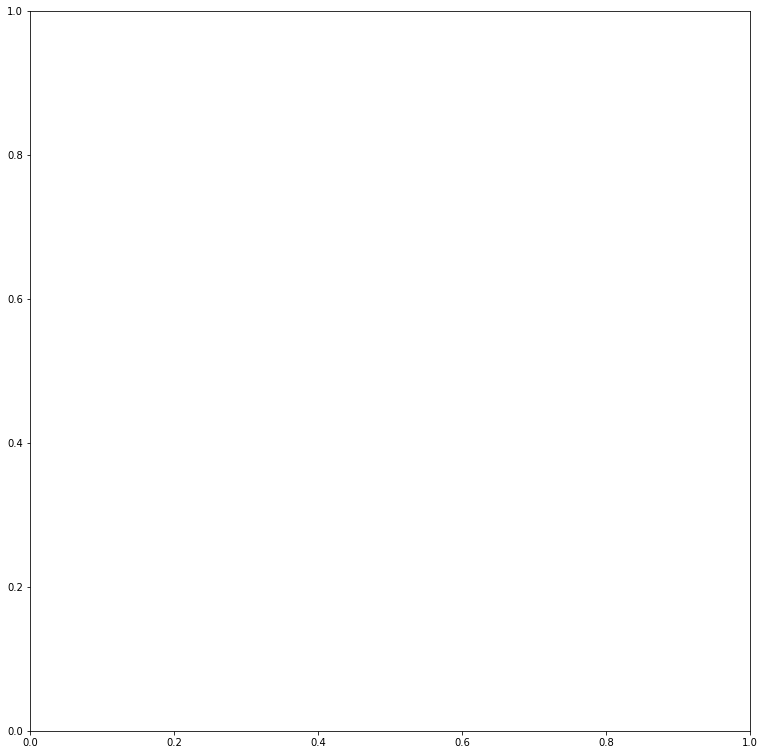

In [250]:
xx = np.arange(10, 22).reshape((12, 1))
yy = np.arange(2, 6).reshape((4, 1))
zz = np.argmax(evaluations, axis=-1).reshape((3, 11))
yy_space, xx_space = np.meshgrid(xx, yy, sparse=True)
print(xx_space.shape)
print(yy_space.shape)
print(zz.shape)
plt.pcolormesh(xx_space, yy_space, zz)
plt.title("Best evaluation method by time alloted and number of points")
plt.show()

In [10]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
update_progress(.5)
update_progress(.2)

Progress: [####----------------] 20.0%


In [67]:
import unittest

class TestEverything(unittest.TestCase):
    
    def test_random_population(self):
        pop = random_population(10000, [(0, 1)])
        self.assertTrue((pop.max()-pop.min())>.9)
        self.assertTrue(np.average(pop)>.45)
        self.assertTrue(np.average(pop)<.55)
        
    def test_radial_mutation(self):
        MUTATION_SIGMA = 1
        pop = np.array([[0]]*10000)
        pop = radial_mutation(pop, [(-100, 100)], function=my_gauss)
        pop = np.sort(pop)
        self.assertTrue(np.average(pop)>-.05)
        self.assertTrue(np.average(pop)<.05)
        #print(pop[15500])
        
        h=np.histogram(pop, bins=(-100, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 100))
        plt.bar(range(12), h[0], width=1)
        
    def test_cross(self):
        self.assertTrue(np.equal(cross(np.array([0]), np.array([0])), np.array([0])).all)
        self.assertTrue(np.equal(cross(np.array([1]), np.array([1])), np.array([1])).all)
        for _ in range(1000):
            c = cross(np.array([0]), np.array([1]))
            self.assertTrue(c[0]==0 or c[0]==.5 or c[0]==1)
        
    def test_graphical_crossover(self):
        for i in range(-10, 11):
            wpop = np.array([[1/100, i]]*100)
            pop = graphical_crossover(wpop)
            self.assertTrue(np.equal(pop,np.array([[i]]*100)).all())
        count = 1000
        weighting = 10000
        weight = np.array(([[1/(2*count)]]*count)+([[1/(2*count)]]*count))
        pop = np.array(([[-1*weighting]]*count)+([[1*weighting]]*count))
        #wpop = np.array([[1/(2*count), -1*weight]]*count+[[1/(2*count), weight]]*count)
        #print(wpop)
        pop = graphical_crossover(pop, weighting=weight)
        #print(pop)
        #print(np.average(pop/weighting))
        self.assertTrue(np.average(pop/weighting)>-.05)
        self.assertTrue(np.average(pop/weighting)<.05)
        #print(len(pop[pop == 0]))
        self.assertFalse(len(pop[pop == 0])>2)
        self.assertTrue(len(pop[pop > 1])>count-int(.05*count))
        self.assertTrue(len(pop[pop < 1])>count-int(.05*count))
        
        
        

#tests
unittest.main(argv=[''], verbosity=2, exit=False)


test_cross (__main__.TestEverything) ... ok
test_graphical_crossover (__main__.TestEverything) ... 

KeyboardInterrupt: 

In [108]:
axies = [(0, 1)]
popu = random_population(10, axies)
print(popu)

[[0.10500691]
 [0.43102323]
 [0.60999711]
 [0.25192745]
 [0.5614949 ]
 [0.95014811]
 [0.95644331]
 [0.03253193]
 [0.35018792]
 [0.52313903]]


In [74]:
popu = mutate(popu, axies)
print(popu)

[[0.27110341]
 [0.05797121]
 [0.40347443]
 [0.25851974]
 [0.89756523]
 [0.03435389]
 [0.01921745]
 [0.69993841]
 [0.07002181]
 [0.49046642]]


In [75]:
weighted_population = np.append(popu/np.sum(popu), popu, axis=1)
#print(weighted_population[:, 0])
#print(weighted_population)
popu = crossover(weighted_population)
print(popu)

[[0.28025862]
 [0.08072103]
 [0.01072677]
 [0.21855099]
 [0.28025862]
 [0.01072677]
 [0.00600052]
 [0.21855099]
 [0.02186383]
 [0.15314479]]


In [82]:
np.apply_along_axis(print, 1, popu)

[0.28025862]
[0.08072103]
[0.01072677]
[0.21855099]
[0.28025862]
[0.01072677]
[0.00600052]
[0.21855099]
[0.02186383]
[0.15314479]


array([None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [101]:
popu.flatten().reshape(popu.shape)

array([[0.28025862],
       [0.08072103],
       [0.01072677],
       [0.21855099],
       [0.28025862],
       [0.01072677],
       [0.00600052],
       [0.21855099],
       [0.02186383],
       [0.15314479]])

In [259]:
a = 1
def ff(b=None):
    global a
    if b:
        a = b
    return a

In [260]:
ff(b=2)

2

In [261]:
ff()

2